In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#all the good old hyperparameters.
np.random.seed(1234)
tf.set_random_seed(1234)
samples = 300
noise = 0.67
NUM_BATCHES= 100
lr = .01
latentDim = 30
latentDim2= 10
latentDim3= 10
latentDim4= 10
lamb = 0.3
batch_size = 1
#h is resolution for descion plot
h = 0.1
circles = 150

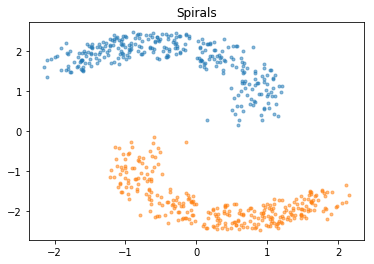

In [3]:
#derived this method for creating data from:https://goo.gl/s46c9a

n = np.sqrt(np.random.rand(samples,1)) * circles * (2*np.pi)/360
#sampling numbers from 0 to 780 (a little more than 2* 360) then convert it to raidans
#trig functions go from -1,1, by scaling it by n we are making them go from ~0 to 15 
#add some noise to make it tasty.
x1 = np.cos(n)*n + np.random.rand(samples,1) * noise
#x1 = np.log(n)
#x2 =  n*np.log(n)
x2 = np.sin(n)*n + np.random.rand(samples,1) * noise
Spiral1 = np.hstack((x1,x2))
Spiral2 = np.hstack((-x1,-x2))
Y = np.hstack((np.zeros(samples),np.ones(samples)))
plt.title("Spirals")
plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)
Spirals = np.vstack((Spiral1,Spiral2))



In [4]:
# # The f(x) we get is not going to produce a probability, we are going to leave that to the TF cross entropy loss boy.
# def f(x): 
#     w1 = tf.get_variable('w1', [2, latentDim], tf.float32, tf.random_normal_initializer())
#     #w2 = tf.get_variable('w2', [latentDim, latentDim2], tf.float32, tf.random_normal_initializer())
#     w2 = tf.get_variable('w2', [latentDim, 1], tf.float32, tf.random_normal_initializer())
#     #w3 = tf.get_variable('w3', [latentDim2, latentDim3], tf.float32, tf.random_normal_initializer())
#     #w4 = tf.get_variable('w4', [latentDim3, 1], tf.float32, tf.random_normal_initializer())
#     b1 = tf.get_variable('b1', [], tf.float32, tf.zeros_initializer())
#     b2 = tf.get_variable('b2', [], tf.float32, tf.zeros_initializer())   
#     return tf.matmul(tf.nn.elu(tf.matmul(x,w1)+ b1), w2) + b2    
#     #b3 = tf.get_variable('b3', [], tf.float32, tf.zeros_initializer())
#     #b4 = tf.get_variable('b4', [], tf.float32, tf.zeros_initializer())
#     #return tf.matmul(tf.sigmoid(tf.matmul(tf.nn.sigmoid(tf.matmul(tf.sigmoid(tf.matmul(x,w1)+ b1), w2) + b2),w3) + b3), w4) + b4

In [5]:
#The f(x) we get is not going to produce a probability, we are going to leave that to the TF cross entropy loss boy.
def f(x): 
    w1 = tf.get_variable('w1', [2, latentDim], tf.float32, tf.random_normal_initializer())
    w2 = tf.get_variable('w2', [latentDim, latentDim2], tf.float32, tf.random_normal_initializer())
    w3 = tf.get_variable('w3', [latentDim2, latentDim3], tf.float32, tf.random_normal_initializer())
    w4 = tf.get_variable('w4', [latentDim3, latentDim4], tf.float32, tf.random_normal_initializer())
    w5 = tf.get_variable('w5', [latentDim4, 1], tf.float32, tf.random_normal_initializer())

    b1 = tf.get_variable('b1', [], tf.float32, tf.zeros_initializer())
    b2 = tf.get_variable('b2', [], tf.float32, tf.zeros_initializer())   
    b3 = tf.get_variable('b3', [], tf.float32, tf.zeros_initializer())
    b4 = tf.get_variable('b4', [], tf.float32, tf.zeros_initializer())
    b5 = tf.get_variable('b5', [], tf.float32, tf.zeros_initializer())
    return tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(tf.nn.tanh(tf.matmul(x,w1)+ b1), w2) + b2),w3) + b3), w4) + b4), w5) + b5

In [6]:
x = tf.placeholder(tf.float32, [batch_size,2])
y = tf.placeholder(tf.float32, [batch_size,1])
w1= tf.placeholder(tf.float32, [2, latentDim])
w2= tf.placeholder(tf.float32, [latentDim,latentDim2])
w3= tf.placeholder(tf.float32, [latentDim2,latentDim3])
w4= tf.placeholder(tf.float32, [latentDim3,latentDim4])
w5= tf.placeholder(tf.float32, [latentDim4,1])

y_hat = f(x)
#loss = tf.losses.sigmoid_cross_entropy(y,y_hat,label_smoothing=5) + lamb*(tf.pow(tf.norm(w1),2) + tf.pow(tf.norm(w2),2))

#loss = tf.losses.sigmoid_cross_entropy(y,y_hat) 
loss = tf.losses.sigmoid_cross_entropy(y,y_hat) + lamb*(tf.pow(tf.norm(w1),2) + tf.pow(tf.norm(w2),2) + tf.pow(tf.norm(w3),2) + tf.pow(tf.norm(w4),2) + tf.pow(tf.norm(w5),2))
optim = tf.train.AdagradOptimizer(lr, 0.3).minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

Tensor("add_4:0", shape=(1, 1), dtype=float32)


In [7]:
tf.get_variable_scope().reuse_variables()
for _ in tqdm(range(0, NUM_BATCHES)):
    choices = np.random.choice(samples,batch_size)
    x_np = Spirals[choices]
    y_np = np.array(Y[choices]).reshape((batch_size,1))
    w1prime   = sess.run(tf.get_variable("w1"))
    w2prime   = sess.run(tf.get_variable("w2"))
    w3prime   = sess.run(tf.get_variable("w3"))
    w4prime   = sess.run(tf.get_variable("w4"))
    w5prime   = sess.run(tf.get_variable("w5"))
    loss_np, _ = sess.run([loss, optim], feed_dict={x: x_np, y: y_np, w1:w1prime, w2:w2prime, w3:w3prime, w4:w4prime, w5:w5prime})
    print(loss_np)
    #loss_np, _ = sess.run([loss, optim], feed_dict={x: x_np, y: y_np, w1:w1prime, w2:w2prime})


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

174.02531


  1%|▊                                                                                 | 1/100 [00:00<00:14,  6.92it/s]

173.92537
174.61754
173.92873
173.90578
173.90869
173.89058
173.90843
173.90192
174.24452
173.8834
173.88892
175.8171
173.88312
173.88048
173.88321
173.88132
173.87889


 18%|██████████████▌                                                                  | 18/100 [00:00<00:01, 72.82it/s]

173.87334
173.93239
173.87299
173.87347
173.88869
173.88316
174.02713
173.89452
173.89008
173.95901
173.89273
173.89714
173.93831
173.89331
173.8836
175.3636
173.87703


 35%|████████████████████████████                                                    | 35/100 [00:00<00:00, 100.31it/s]

173.90271
173.87141
173.88048
173.88248
173.89827
173.88737
173.87636
173.88562
173.88857
174.31615
173.89098
173.89532
173.89622
173.8948
173.89543
173.88635
173.89885
173.89734
173.90182
173.90051
173.90271


 56%|████████████████████████████████████████████▊                                   | 56/100 [00:00<00:00, 123.17it/s]

173.90228
173.8867
173.90163
173.89476
173.8968
173.9034
173.89317
173.89171
173.89702
173.89948
173.90895
173.89906
173.90509


 69%|███████████████████████████████████████████████████████▏                        | 69/100 [00:00<00:00, 123.35it/s]

173.90915
173.90112
173.90164
173.91074
173.90488
173.91235
173.9871
173.89806
173.90834
173.91634
173.91893
173.91957
173.91855


 82%|█████████████████████████████████████████████████████████████████▌              | 82/100 [00:00<00:00, 121.29it/s]

173.92073
173.90797
173.92041
173.92174
173.90851
173.99509
173.92241
173.92409
173.91072
173.91272
173.92719
173.92857
173.92787


 95%|████████████████████████████████████████████████████████████████████████████    | 95/100 [00:00<00:00, 122.14it/s]

173.9145
173.93091
173.92511
173.93202
173.96423


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.82it/s]


In [8]:
#Now need to plot the descion boundary. 

#basically we are just going to sample a bunchacrunch points, pass em through the network and then matplotlib do a filled contour

xx,yy = np.meshgrid(np.arange(-7,7,h), np.arange(-7,7,h))
inputx = np.stack((xx,yy), axis=2)


In [9]:
y_hats = np.array([])
a = tf.placeholder(tf.float32, [inputx.shape[0],2])
y_hat = f(a)

for i in tqdm(range(inputx.shape[0])):
    if y_hats.size>0: 
        y_hats = np.hstack((y_hats,sess.run(y_hat,{a:inputx[i]})))
    else: 
        y_hats = sess.run(y_hat,{a:inputx[i]})
    


Tensor("add_19:0", shape=(140, 1), dtype=float32)


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 1711.89it/s]


In [10]:
#change them either to have zero or 1....
y_hats[y_hats>0] = 1
y_hats[y_hats<=0] = 0

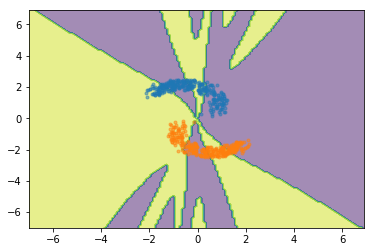

In [11]:
plt.contourf(xx,yy,y_hats,alpha=0.5)

plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)